In [24]:
from processing.preprocessing import BCIDataProcessor
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import numpy as np
import matplotlib.pyplot as plt

In [34]:
recording_path_1 = '../recordings/recording_imagery1.raw.fif'
recording_path_2 = '../recordings/recording_ssvep2.raw.fif'
recording_path_3 = '../recordings/recording_ssvep4_gel.raw.fif'
rescale = True
window_size = 2
window_overlap = 1.5
filter_method = 'iir'
l_freq, h_freq = 7, 30

processor = BCIDataProcessor(recording_path_1, l_freq=l_freq, h_freq=h_freq, window_size=window_size,
                             window_overlap=window_overlap, rescale=rescale, filter_method=filter_method)
data = processor.process()
data

{'left_hand': array([[[ 1.55115286e-08, -6.50174189e-07, -3.14714564e-07, ...,
          -4.67335149e-06, -3.55992971e-06, -1.00008114e-06],
         [ 8.80863239e-09, -7.54518462e-07, -5.99632640e-07, ...,
          -9.37311204e-08,  6.15463054e-07,  2.26356813e-06],
         [ 5.55602266e-09,  1.13543417e-06,  2.62916962e-06, ...,
           6.31902838e-07,  3.72385602e-07,  1.58972644e-06],
         ...,
         [ 1.35371485e-08, -1.86277545e-06, -2.62593054e-06, ...,
          -2.28226124e-06,  2.14798933e-07,  3.62570745e-06],
         [ 7.23382230e-09,  1.45082599e-06,  3.02338869e-06, ...,
          -4.18458162e-07, -5.36727221e-07,  7.97019718e-07],
         [ 3.50282796e-09,  2.37419448e-06,  4.55164878e-06, ...,
           1.72564339e-06,  1.56141112e-06,  2.65029267e-06]],
 
        [[-4.94119802e-06, -6.68048063e-06, -9.67790548e-06, ...,
           1.36775761e-05,  7.34352466e-06, -1.92501351e-07],
         [-4.15572925e-06, -5.48374616e-06, -7.88459065e-06, ...,
        

In [35]:
# EEGNet Model
class EEGNet(nn.Module):
    def __init__(self, num_classes, Chans=64, Samples=128, dropout_rate=0.5):
        super(EEGNet, self).__init__()
        self.firstconv = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=(1, 64), bias=False),
            nn.BatchNorm2d(8)
        )
        self.depthwiseConv = nn.Sequential(
            nn.Conv2d(8, 16, kernel_size=(Chans, 1), groups=8, bias=False),
            nn.BatchNorm2d(16),
            nn.ELU(),
            nn.AvgPool2d(kernel_size=(1, 4)),
            nn.Dropout(dropout_rate)
        )
        self.separableConv = nn.Sequential(
            nn.Conv2d(16, 16, kernel_size=(1, 16), padding=(0, 8), bias=False),
            nn.BatchNorm2d(16),
            nn.ELU(),
            nn.AvgPool2d(kernel_size=(1, 8)),
            nn.Dropout(dropout_rate)
        )
        final_feature_size = 16 * ((Samples - 63) // 32)
        self.classify = nn.Linear(final_feature_size, num_classes)

    def forward(self, x):
        x = self.firstconv(x)
        x = self.depthwiseConv(x)
        x = self.separableConv(x)
        x = x.view(x.size(0), -1)
        return self.classify(x)

# Dataset Class
class EEGDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32).permute(0, 3, 1, 2)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [37]:
X = np.concatenate(list(data.values()), axis=0)
y = np.concatenate([[label] * data[label].shape[0] for label in data.keys()])  # (samples,)
# Add depth to X (samples, channels, time, 1)
X = X[:, :, :, np.newaxis]  # (samples, channels, time, 1)
# Make y numerical
label_dict = {
    'left_hand': 0,
    'right_hand': 1,
}
y = np.array([label_dict[label] for label in y])
X.shape, y.shape

((208, 8, 500, 1), (208,))

In [44]:
# Define parameters
batch_size = 128
lr = 0.001
dropout_rate = 0.5
criterion = nn.CrossEntropyLoss()
n_epochs = 150
weight_decay = 1e-3
num_classes = len(label_dict)  # Number of classes

# Prepare Data
n_samples, n_channels, n_times, _ = X.shape
dataset = EEGDataset(X, y)

train_size = int(0.8 * len(dataset))
train_set, test_set = random_split(dataset, [train_size, len(dataset) - train_size])

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

# Model Config
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EEGNet(num_classes=num_classes, Chans=n_channels, Samples=n_times, dropout_rate=dropout_rate).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

# Print settings
print("=== EEGNet Training Settings ===")
print(f"Device: {device}")
print(f"Model: EEGNet")
print(f"Input shape: {X.shape}")
print(f"Training samples: {train_size}, Test samples: {len(dataset) - train_size}")
print(f"Epochs: {n_epochs}, Batch size: 32")
print(f"Optimizer: {optimizer.__class__.__name__}")
print(f"Learning rate: {lr}, Weight decay: {weight_decay}")
print(f"Dropout rate: {dropout_rate}")
print(f"Loss function: {criterion.__class__.__name__}")
print("=================================")


=== EEGNet Training Settings ===
Device: cpu
Model: EEGNet
Input shape: (208, 8, 500, 1)
Training samples: 166, Test samples: 42
Epochs: 150, Batch size: 32
Optimizer: Adam
Learning rate: 0.001, Weight decay: 0.001
Dropout rate: 0.5
Loss function: CrossEntropyLoss


In [45]:
# Training Loop
train_losses, test_losses = [], []

for epoch in range(n_epochs):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * X_batch.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == y_batch).sum().item()
        total += y_batch.size(0)

    train_acc = correct / total
    train_loss = running_loss / total
    train_losses.append(train_loss)

    # Validation
    model.eval()
    test_loss, correct_test, total_test = 0.0, 0, 0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            test_loss += loss.item() * X_batch.size(0)
            _, predicted = torch.max(outputs, 1)
            correct_test += (predicted == y_batch).sum().item()
            total_test += y_batch.size(0)

    test_acc = correct_test / total_test
    test_loss = test_loss / total_test
    test_losses.append(test_loss)

    print(f"Epoch {epoch+1}/{n_epochs} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.4f}")

Epoch 1/150 | Train Loss: 0.6980 | Train Acc: 0.5422 | Test Loss: 0.6947 | Test Acc: 0.4762
Epoch 2/150 | Train Loss: 0.7123 | Train Acc: 0.5060 | Test Loss: 0.6949 | Test Acc: 0.4762
Epoch 3/150 | Train Loss: 0.6889 | Train Acc: 0.5904 | Test Loss: 0.6950 | Test Acc: 0.4762
Epoch 4/150 | Train Loss: 0.6947 | Train Acc: 0.5060 | Test Loss: 0.6951 | Test Acc: 0.4762
Epoch 5/150 | Train Loss: 0.6989 | Train Acc: 0.5120 | Test Loss: 0.6952 | Test Acc: 0.4762
Epoch 6/150 | Train Loss: 0.6808 | Train Acc: 0.5422 | Test Loss: 0.6952 | Test Acc: 0.4762
Epoch 7/150 | Train Loss: 0.6899 | Train Acc: 0.5482 | Test Loss: 0.6952 | Test Acc: 0.4762
Epoch 8/150 | Train Loss: 0.6870 | Train Acc: 0.5602 | Test Loss: 0.6951 | Test Acc: 0.4762
Epoch 9/150 | Train Loss: 0.6869 | Train Acc: 0.5602 | Test Loss: 0.6951 | Test Acc: 0.4762
Epoch 10/150 | Train Loss: 0.6909 | Train Acc: 0.5482 | Test Loss: 0.6951 | Test Acc: 0.4762
Epoch 11/150 | Train Loss: 0.6817 | Train Acc: 0.5843 | Test Loss: 0.6951 | Tes

KeyboardInterrupt: 

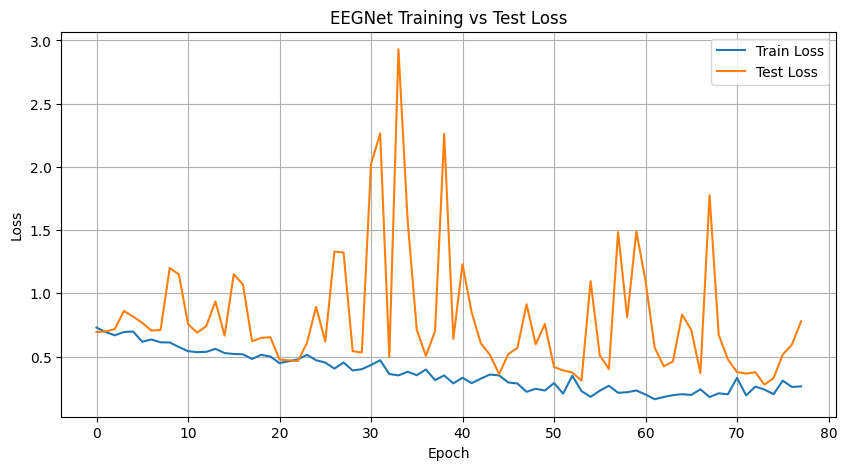

In [41]:
# Plot learning curves
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title("EEGNet Training vs Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()